참고 : https://github.com/yellowjs0304/3-min-pytorch_study/blob/master/09-%EA%B2%BD%EC%9F%81%ED%95%98%EB%A9%B0_%ED%95%99%EC%8A%B5%ED%95%98%EB%8A%94_GAN/conditional_gan.ipynb

In [14]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# 하이퍼파라미터
EPOCHS = 200
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [16]:
#Fashion MNIST dataset Link : https://knowyourdata-tfds.withgoogle.com/#tab=STATS&dataset=fashion_mnist
trainset = datasets.FashionMNIST(
    './.data',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True
)


In [17]:
# 생성자 모델 생성
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.embed = nn.Embedding(10,10)
    # 배치 x 1크기의 레이블 텐서 -> 배치 * 10의 연속적인 텐서로 변환
    # 매번 똑같은 레이블은 항상 똑같은 텐서를 생성하기에, 단순히 연속적인 텐서를 레이블값에 매핑하기 위함
    # (연속적인 값이 학습에 더 유용하다.) ??
    
    self.model = nn.Sequential(
        nn.Linear(110, 256),
        nn.LeakyReLU(0.2, inplace= True), #inplace = True인자 : 입력을 복사하지않고 조작
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2, inplace= True),
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2, inplace= True),
        nn.Linear(1024, 784), #레이블이 추가되었으니 layer를 한 층 더늘려서 조금더 복잡하게 구현
        nn.Tanh() #-1과 1사이의 값으로 반환
    )

  def forward(self, z, labels):
    c = self.embed(labels)
    x = torch.cat([z, c], 1)
    return self.model(x)

In [18]:
# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        # 배치 x 1크기의 레이블 텐서==>배치 x 10의 연속적인 텐서로 전환
        # 매번 똑같은 레이블은 항상 똑같은 텐서를 만들기 때문에, 단순히 연속적인 텐서를 레이블 값에 맵핑하기 위함.
        # (연속적인 값이 학습에 더 유용)
        #Dropout() : 레이어간의 연결 중 일부를 랜덤하게 삭제 -> 일반화 성능이 높아진다고 함
        self.model = nn.Sequential(
            nn.Linear(794, 1024),# 레이블 정보를 전달하기 위해 이미지 크기(784)에 10
            nn.LeakyReLU(0.2, inplace=True),#판별자에게도 794노드에서 1024노드를 출력하는 계층 하나와 
            nn.Dropout(0.3), #성능을 늘리기 위해 드롭아웃 계층을 2개 더 추가
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()#Sigmoid() 함수를 거쳐 각각 가짜와 진짜를 뜻하는 0,1 사이를 반환
        )
    
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x, c], dim= 1) #1차원으로 x와 c 텐서를 더함
        return self.model(x)

In [19]:
# 모델 인스턴스를 만들고 모델의 가중치를 지정한 장치로 보내기
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

# 이진 교차 엔트로피 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr =0.0002)
g_optimizer = optim.Adam(G.parameters(), lr =0.0002)

In [20]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)

        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산 (데이터셋 레이블 입력)
        labels = labels.to(DEVICE)
        outputs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
    
        # 무작위 텐서와 무작위 레이블을 생성자에 입력해 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
        # g_label= torch.randint로 0과 10 사이의 값을 가진 배치x 1 크기의 텐서
        g_label = torch.randint(0, 10, (BATCH_SIZE,)).to(DEVICE)
        fake_images = G(z, g_label)# z와 g_label관 관계성을 Generator가 학습하도록 한다.
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        outputs = D(fake_images, g_label)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake
        
        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차 계산(무작위 레이블 입력)
        fake_images = G(z, g_label)
        outputs = D(fake_images, g_label)
        g_loss = criterion(outputs, real_labels)

        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    print('이폭 [{}/{}] d_loss:{:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)):{:.2f}'
          .format(epoch,
                  EPOCHS,
                  d_loss.item(),
                  g_loss.item(),
                  real_score.mean().item(),
                  fake_score.mean().item()))

이폭 [0/200] d_loss:0.3050 g_loss: 4.3532 D(x):0.93 D(G(z)):0.13
이폭 [1/200] d_loss:0.3644 g_loss: 3.9753 D(x):0.91 D(G(z)):0.15
이폭 [2/200] d_loss:0.3579 g_loss: 4.0775 D(x):0.95 D(G(z)):0.15
이폭 [3/200] d_loss:0.1952 g_loss: 4.7136 D(x):0.95 D(G(z)):0.10
이폭 [4/200] d_loss:0.4051 g_loss: 2.4078 D(x):0.87 D(G(z)):0.15
이폭 [5/200] d_loss:0.4839 g_loss: 2.4815 D(x):0.90 D(G(z)):0.23
이폭 [6/200] d_loss:0.7538 g_loss: 2.4541 D(x):0.76 D(G(z)):0.20
이폭 [7/200] d_loss:0.8506 g_loss: 1.7604 D(x):0.79 D(G(z)):0.31
이폭 [8/200] d_loss:0.7369 g_loss: 1.8843 D(x):0.79 D(G(z)):0.25
이폭 [9/200] d_loss:0.8559 g_loss: 1.8038 D(x):0.70 D(G(z)):0.24
이폭 [10/200] d_loss:0.8279 g_loss: 1.5007 D(x):0.70 D(G(z)):0.28
이폭 [11/200] d_loss:1.0355 g_loss: 1.5079 D(x):0.74 D(G(z)):0.35
이폭 [12/200] d_loss:0.5887 g_loss: 1.6348 D(x):0.79 D(G(z)):0.22
이폭 [13/200] d_loss:0.6255 g_loss: 1.7009 D(x):0.79 D(G(z)):0.25
이폭 [14/200] d_loss:1.1453 g_loss: 1.5059 D(x):0.62 D(G(z)):0.32
이폭 [15/200] d_loss:0.8385 g_loss: 1.5298 D(x):0.72

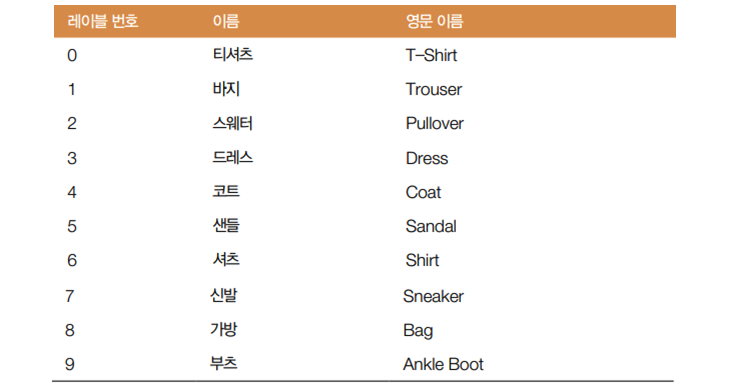

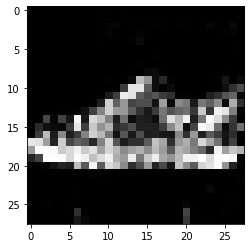

In [22]:
# 만들고 싶은 아이템 생성하고 시각화하기
item_number = 7 # 아이템 번호
z = torch.randn(1, 100).to(DEVICE) # 배치 크기 1
g_label = torch.full((1,), item_number, dtype=torch.long).to(DEVICE)
sample_images = G(z, g_label)

sample_images_img = np.reshape(sample_images.data.cpu().numpy()
                               [0],(28, 28))
plt.imshow(sample_images_img, cmap = 'gray')
plt.show()